In [90]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from datetime import date
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.stats import boxcox
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

In [91]:
# df = pd.read_csv("F:\\My Laptop\\UL\\MSc Artificial Intelligence and Machine Learning\\Semester 2\\Theory and Practice of Advanced AI Systems\\Final Project\\dataanime.csv") 

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
data_file = "/content/drive/MyDrive/dataanime.csv"

In [94]:
df = pd.read_csv(data_file) 

In [95]:
def Convert_To_Str(df, columns):
  for i in columns:
    df[i] = df[i].astype("string")
  return df

In [96]:
def df_train_test(df, test_size, DV, random_state):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df.drop([DV], axis = 1), df[DV], test_size=test_size, random_state=random_state)
    df_train = X_train.join(y_train)
    df_test = X_test.join(y_test)
    return df_train, df_test

In [97]:
def Reset_Index(df):
  return df.reset_index(drop=True)

In [98]:
def MV_Using_DV(features, MV_terms, DV, df_train, df_test):
  Ft_MV_Dict = dict(zip(features, MV_terms))
  for i,j in Ft_MV_Dict.items():
    DV_groupby = df_train.groupby(i)[DV].agg(np.mean).sort_values().to_frame()
    DV_groupby.reset_index(level=0, inplace=True)
    MV_replacement = DV_groupby.loc[DV_groupby[i] == j].index-1
    if MV_replacement >= 0:
      if DV_groupby[i].iloc[MV_replacement].empty == False:
        df_train[i].replace([j], DV_groupby[i].iloc[MV_replacement], inplace = True)
        df_test[i].replace([j], DV_groupby[i].iloc[MV_replacement], inplace = True)
    else:
      if DV_groupby[i].iloc[MV_replacement+2].empty == False:
        df_train[i].replace([j], DV_groupby[i].iloc[MV_replacement+2], inplace = True)
        df_test[i].replace([j], DV_groupby[i].iloc[MV_replacement+2], inplace = True)
  return {
    'df_train':df_train,
    'df_test':df_test
  }

def MV_Using_Strategy(df_train, df_test, strategy, MV_term, feature):
  from sklearn.impute import SimpleImputer
  imputer = SimpleImputer(missing_values=MV_term, strategy=strategy)
  df_train[feature] = imputer.fit_transform(df_train[feature].values.reshape(-1,1))[:,0]
  df_test[feature].replace([MV_term], "NaN", inplace = True)
  df_test[feature].replace(["NaN"], imputer.statistics_[0], inplace = True)
  return df_train, df_test

def MV_Specific(df_train, df_test, MV_term, replace_term, feature):
  df_train[feature].replace([MV_term], f"{replace_term}", inplace = True)
  df_test[feature].replace([MV_term], f"{replace_term}", inplace = True)
  return df_train, df_test

def Convert_To(df, feature, type):
  return df[feature].astype(type)

In [99]:
def df_head(df):
  return display(df.head())

In [100]:
def One_Hot_Encoding(df_train, df_test, feature_list):
  for i in feature_list:
    df_train = df_train.join(pd.get_dummies(df_train[i], prefix = i, prefix_sep = "_"))
    df_test = df_test.join(pd.get_dummies(df_test[i], prefix = i, prefix_sep = "_"))
    df_train.drop(columns = [i], inplace = True)
    df_test.drop(columns = [i], inplace = True)
  return df_train, df_test

In [101]:
def Add_Period_Column(df, feature, dt_format = "%Y-%m-%d", MV_term = "-", Period_Type = "y"):
  feature_store = []
  for i in df[feature]:
    if i != MV_term:
      if Period_Type == 'y':
        feature_store.append(datetime.strptime(i, dt_format).year)
      elif Period_Type == 'm':
        feature_store.append(datetime.strptime(i, dt_format).month)
    else: 
      feature_store.append(i)
  if Period_Type == 'y':
    df_Year = pd.DataFrame(feature_store,columns=[f'{feature} Year'])
  elif Period_Type == 'm':
    df_Month = pd.DataFrame(feature_store,columns=[f'{feature} Month'])
  if Period_Type == 'y':
    return df.join(df_Year)
  elif Period_Type == 'm':
    return df.join(df_Month)

In [102]:
def Bin_Years(df_train, df_test, feature, q):
  res, bins = pd.qcut(df_train[feature], q = q, retbins = True, duplicates='drop')
  df_train.insert(len(df_train.columns), f"{feature} Period", res)
  df_test.insert(len(df_test.columns), f"{feature} Period", pd.cut(df_test[feature], bins, duplicates = 'drop'))
  df_train.drop(columns = [feature], inplace = True)
  df_test.drop(columns = [feature], inplace = True)
  return df_train, df_test

In [103]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))
    print("R-Squared: ", r2_score(y_test, y_pred))

In [104]:
def Convert_To_Mins(df, feature):
  df[feature].replace(["per ep."], "", inplace = True)
  Duration_df = df[feature].str.split("hr", n = 1, expand = True)
  Duration_df.loc[(Duration_df[0].str.contains("min"))|(Duration_df[0].str.contains("sec")), 1] = Duration_df[0]
  Duration_df[0] = Duration_df[0].astype('string')
  Duration_df.loc[(Duration_df[0].str.contains("min"))|(Duration_df[0].str.contains("sec")), 0] = "0"
  Duration_df[0].replace(["-"], 0, inplace = True)
  Duration_df[0] = Duration_df[0].astype(int)
  Duration_df[0] = Duration_df[0]*60
  Duration_df[1] = Duration_df[1].str.extract(r'(\d+.+$)')[0]
  Duration_df[1] = Duration_df[1].astype('string')
  try:
    Impute_For_Secs = int(Duration_df.loc[(Duration_df[1].str.contains("sec")) & (~Duration_df[1].str.contains("min", na=False)), 1].str.split(expand = True)[0])/60
    Duration_df.loc[Duration_df[1].str.contains("sec"), 1] = str(Impute_For_Secs)
  except KeyError: 
    pass
  Duration_df[1].str.split(" ", n = 1, expand = True)
  Duration_df[1] = Duration_df[1].str.split(" ", n = 1, expand = True)
  Duration_df[1] = Duration_df[1].astype('string')
  Duration_df[1].replace([None], "0", inplace = True)
  Duration_df[1] = Duration_df[1].astype(float)
  df[f"{feature}_in_mins"] = Duration_df[0]+Duration_df[1]
  df.drop(columns = [feature], inplace = True)
  return df

In [105]:
def One_Hot_Delim(df_train, df_test, features, separators):
  Ft_Sep_Dict = dict(zip(features, separators))
  for i,j in Ft_Sep_Dict.items():
    df_Feature = df_train[i].str.get_dummies(sep=j).add_prefix(f'{i}_')
    df_train = df_train.join(df_Feature)
    df_train.drop(columns = [i], inplace = True)
    df_Feature = df_test[i].str.get_dummies(sep=j).add_prefix(f'{i}_')
    df_test = df_test.join(df_Feature)
    df_test.drop(columns = [i], inplace = True)
  return df_train, df_test

In [106]:
def Range_Outlier(df_train, df_test, feature, range, IQR_multiple):
  Q1,Q3 = np.percentile(sorted(df_train[feature]),range)
  IQR = Q3 - Q1
  lower_range = Q1 - (IQR_multiple * IQR)
  upper_range = Q3 + (IQR_multiple * IQR)
  df_train.loc[df_train[feature]<lower_range, feature] = lower_range
  df_train.loc[df_train[feature]>upper_range, feature] = upper_range  
  df_test.loc[df_test[feature]<lower_range, feature] = lower_range
  df_test.loc[df_test[feature]>upper_range, feature] = upper_range
  return df_train, df_test

In [107]:
def Drop_Columns(df, Cols_To_Drop_List):
  df.drop(columns = Cols_To_Drop_List, inplace = True)
  return df

In [108]:
def cubert_feature(df, feature):
  df[f"{feature}_cubert"] = df[feature]**(1/3)
  return df

In [109]:
def log2(df_train, df_test, feature_list):
  for i in feature_list:
    df_train[f"log2_{i}"] = np.log2(df_train[i])
    df_test[f"log2_{i}"] = np.log2(df_test[i])
  return df_train, df_test

In [110]:
def boxplot(SeriesData):
  sns.boxplot(x=SeriesData)

In [111]:
def FS_KHighest(X_train,y_train, X_test, score_func, k):
  fs = SelectKBest(score_func=score_func, k=k)
  fs.fit(X_train, y_train)
  X_train = fs.transform(X_train)
  X_test = fs.transform(X_test)
  return X_train, X_test

In [112]:
def ScaleX(X_train, X_test, ScaleType='Standard', norm = 'l1'):
  if ScaleType == "Standard":
    X_train = StandardScaler().fit_transform(X_train.values)
    X_test = StandardScaler().fit_transform(X_test.values)
  if ScaleType == "MinMax":
    X_train = MinMaxScaler().fit_transform(X_train.values)
    X_test = MinMaxScaler().fit_transform(X_test.values)
  if ScaleType == "Normalize":
    X_train = preprocessing.normalize(X_train, norm=norm)
    X_test = preprocessing.normalize(X_test, norm=norm)

  return X_train, X_test

In [113]:
def Separate_Y(df_train, df_test, DV, Multiple_Dummies = True):
  X_train = df_train.drop([DV], axis = 1)
  y_train = df_train[DV]
  X_test = df_test.drop([DV], axis = 1)
  y_test = df_test[DV]
  
  if Multiple_Dummies == True:
    dummy_drop_list = []
    for i in X_train.columns:
      if i not in X_test.columns:
        dummy_drop_list.append(i)
    df_train.drop(columns = dummy_drop_list, inplace = True)
    dummy_drop_list = []
    for i in X_test.columns:
      if i not in X_train.columns:
        dummy_drop_list.append(i)
    df_test.drop(columns = dummy_drop_list, inplace = True)

    X_train = df_train.drop([DV], axis = 1)
    y_train = df_train[DV]
    X_test = df_test.drop([DV], axis = 1)
    y_test = df_test[DV]
  return X_train, y_train, X_test, y_test


In [114]:
def Remove_Multicolliearity(df_train, df_test, DV):
    #Source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=The%20Problem%20with%20having%20Multicollinearity,-Multicollinearity%20can%20be&text=Multicollinearity%20may%20not%20affect%20the,when%20it%20comes%20to%20interpretability.
    # The below code may run for a good amount of time - took us 2 hours to perform the operation for 1500 rows and 370 columns 
    import warnings
    warnings.filterwarnings("ignore")
    X_train = df_train.drop([DV], axis = 1)
    y_train = df_train[DV]
    X_test = df_test.drop([DV], axis = 1)
    y_test = df_test[DV]
    VIF_df = pd.DataFrame()
    VIF_df["variables"] = X_train.columns
    VIF_df["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    
    Cols_HighVIF = []
    while len(VIF_df.loc[VIF_df['VIF']>10])>0:
        if VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'] in X_train.columns:
            X_train.drop(columns = VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'], inplace = True)
            Cols_HighVIF.append(VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'])
            print("Deleted Feature: ", VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'])
        if VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'] in X_test.columns:
            X_test.drop(columns = VIF_df.loc[VIF_df[['VIF']].idxmax()[0]]['variables'], inplace = True)
        VIF_df = pd.DataFrame()
        VIF_df["variables"] = X_train.columns
        VIF_df["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    df_train = X_train.join(y_train)
    df_test = X_test.join(y_test)
    try:
        Cols_HighVIF = pd.DataFrame(Cols_HighVIF)
        Cols_HighVIF.to_csv('Cols_HighVIF.csv')
    except Exception as e:
        print(Cols_HighVIF)
        print(e)
    return df_train, df_test

In [115]:
def Create_DoL(L1, L2):
  d = dict(zip(L1, L2))
  return d

In [116]:
def RF_Eval(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
    print('R-Squared:', r2_score(y_test, y_pred))

In [117]:
def Lin_Reg(X_train, y_train, X_test, y_test):
    reg = LinearRegression()  
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print("R-Squared: ", r2_score(y_test, y_pred))

In [118]:
def Ridge_Eval(X_train, y_train, X_test, y_test, alpha):
  rdg = Ridge(alpha = alpha)
  rdg.fit(X_train, y_train)
  y_pred = rdg.predict(X_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print("R-Squared: ", r2_score(y_test, y_pred))

In [119]:
def SVR_Eval(X_train, y_train, X_test, y_test, C, gamma):
  svr = SVR(C = C, gamma = gamma)
  svr.fit(X_train, y_train)
  y_pred = svr.predict(X_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print("R-Squared: ", r2_score(y_test, y_pred))

In [120]:
df_train, df_test=df_train_test(df, 0.33, "Score", 42)

In [121]:
df.shape, df_train.shape, df_test.shape

((1563, 20), (1047, 20), (516, 20))

In [122]:
df_train.head()

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score
700,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87
1239,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61
741,Mind Game,Movie,1,Finished Airing,2004-8-7,-,-,-,Beyond C.,GKIDS,Studio 4°C,Manga,"Adventure,Comedy,Dementia,Psychological,Romance",1 hr. 44 min.,R,16880,41888,600,Nishi has always loved Myon since they were li...,7.85
936,Urusei Yatsura,TV,195,Finished Airing,1981-10-14,1986-3-19,Fall,-,"Kitty Films,Fuji TV",AnimEigo,"Studio Pierrot,Studio Deen",Manga,"Action,Sci-Fi,Adventure,Comedy,Drama,Romance",25 min. per ep.,PG-13,5521,33689,526,Not much is notable about the lecherous Ataru ...,7.75
965,Mobile Suit Gundam 00 Special Edition,OVA,3,Finished Airing,2009-10-27,2010-2-23,-,-,"Sotsu,Asatsu DK,Mainichi Broadcasting System",-,Sunrise,-,"Action,Drama,Mecha,Military,Sci-Fi",1 hr. 30 min. per ep.,PG-13,2837,8217,37,Condensed version of both the first and second...,7.73


In [123]:
df_train = Reset_Index(df_train)
df_test = Reset_Index(df_test)
df_train.head()

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61
2,Mind Game,Movie,1,Finished Airing,2004-8-7,-,-,-,Beyond C.,GKIDS,Studio 4°C,Manga,"Adventure,Comedy,Dementia,Psychological,Romance",1 hr. 44 min.,R,16880,41888,600,Nishi has always loved Myon since they were li...,7.85
3,Urusei Yatsura,TV,195,Finished Airing,1981-10-14,1986-3-19,Fall,-,"Kitty Films,Fuji TV",AnimEigo,"Studio Pierrot,Studio Deen",Manga,"Action,Sci-Fi,Adventure,Comedy,Drama,Romance",25 min. per ep.,PG-13,5521,33689,526,Not much is notable about the lecherous Ataru ...,7.75
4,Mobile Suit Gundam 00 Special Edition,OVA,3,Finished Airing,2009-10-27,2010-2-23,-,-,"Sotsu,Asatsu DK,Mainichi Broadcasting System",-,Sunrise,-,"Action,Drama,Mecha,Military,Sci-Fi",1 hr. 30 min. per ep.,PG-13,2837,8217,37,Condensed version of both the first and second...,7.73


In [124]:
df_train.groupby('Sources')['Score'].agg(np.mean).sort_values()

Sources
Card game       7.640000
Game            7.711818
-               7.738873
Book            7.805000
Music           7.807500
4-koma manga    7.833333
Other           7.844545
Web manga       7.872917
Original        7.886392
Light novel     7.927727
Manga           7.950611
Novel           7.967500
Picture book    8.080000
Visual novel    8.084815
Name: Score, dtype: float64

In [125]:
df_train.columns

Index(['Title', 'Type', 'Episodes', 'Status', 'Start airing', 'End airing',
       'Starting season', 'Broadcast time', 'Producers', 'Licensors',
       'Studios', 'Sources', 'Genres', 'Duration', 'Rating', 'Scored by',
       'Members', 'Favorites', 'Description', 'Score'],
      dtype='object')

In [126]:
df_train.groupby('Rating')['Score'].agg(np.mean).sort_values()

Rating
PG       7.783171
G        7.846374
PG-13    7.915000
None     7.956667
R        7.957549
Name: Score, dtype: float64

In [127]:
df_train.groupby('Rating')['Score'].agg(np.mean).sort_values()

Rating
PG       7.783171
G        7.846374
PG-13    7.915000
None     7.956667
R        7.957549
Name: Score, dtype: float64

In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047 entries, 0 to 1046
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1047 non-null   object 
 1   Type             1047 non-null   object 
 2   Episodes         1047 non-null   object 
 3   Status           1047 non-null   object 
 4   Start airing     1047 non-null   object 
 5   End airing       1047 non-null   object 
 6   Starting season  1047 non-null   object 
 7   Broadcast time   1047 non-null   object 
 8   Producers        1047 non-null   object 
 9   Licensors        1047 non-null   object 
 10  Studios          1047 non-null   object 
 11  Sources          1047 non-null   object 
 12  Genres           1047 non-null   object 
 13  Duration         1047 non-null   object 
 14  Rating           1047 non-null   object 
 15  Scored by        1047 non-null   int64  
 16  Members          1047 non-null   int64  
 17  Favorites     

In [129]:
columns = ['Title', 'Type', 'Episodes', 'Status', 'Start airing', 'End airing', 'Starting season', 'Broadcast time', 'Producers', 'Licensors', 'Studios', 'Sources', 'Genres', 'Duration', 'Rating', 'Description']
df = Convert_To_Str(df, columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563 entries, 0 to 1562
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1563 non-null   string 
 1   Type             1563 non-null   string 
 2   Episodes         1563 non-null   string 
 3   Status           1563 non-null   string 
 4   Start airing     1563 non-null   string 
 5   End airing       1563 non-null   string 
 6   Starting season  1563 non-null   string 
 7   Broadcast time   1563 non-null   string 
 8   Producers        1563 non-null   string 
 9   Licensors        1563 non-null   string 
 10  Studios          1563 non-null   string 
 11  Sources          1563 non-null   string 
 12  Genres           1563 non-null   string 
 13  Duration         1563 non-null   string 
 14  Rating           1563 non-null   string 
 15  Score            1563 non-null   float64
 16  Scored by        1563 non-null   int64  
 17  Members       

In [130]:
pd.set_option('display.max_rows', 500)
df_train['Episodes'].value_counts().head(20)

1     347
12    113
13     96
26     70
24     46
25     44
2      42
3      23
11     19
4      19
52     14
22     14
10     13
50     12
6      11
51     11
39     11
8      10
-       9
7       8
Name: Episodes, dtype: int64

In [131]:
df_train, df_test = MV_Using_Strategy(df_train, df_test, 'most_frequent', "-", "Episodes")

In [132]:
df_train['Episodes'].dtype

dtype('O')

In [133]:
df_train['Episodes'] = Convert_To(df_train, 'Episodes', int)
df_test['Episodes'] = Convert_To(df_test,'Episodes', int)

In [134]:
df_train['Episodes'].dtype

dtype('int64')

In [135]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61


In [136]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61


In [137]:
df_train["Start airing"].dtype

dtype('O')

In [138]:
df_train["Start airing"] = Convert_To(df_train, 'Start airing', 'string')

In [139]:
df_train["Start airing"].dtype

StringDtype

In [140]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61


In [141]:
df_train["Start airing"] = Convert_To(df_train, 'Start airing', 'string')
df_train = Add_Period_Column(df_train, 'Start airing', '%Y-%m-%d', '-', 'y')
df_test = Add_Period_Column(df_test, 'Start airing', '%Y-%m-%d', '-', 'y')

In [142]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),-,-,Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,2010
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,2014


In [143]:
df_dict = MV_Using_DV(['Rating', 'Sources', 'Producers', 'Licensors', 'Studios', 'Start airing', 'Start airing Year'], ['None','-', '-', '-', '-', "-", "-"], "Score", df_train, df_test)
df_train = df_dict["df_train"]
df_test = df_dict["df_test"]

In [144]:
df_train['Start airing Year'] = Convert_To(df_train, 'Start airing Year', "int")
df_train, df_test = Bin_Years(df_train, df_test, 'Start airing Year', 5)

In [145]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year Period
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),"TV Tokyo,Aniplex,Square Enix,Nihon Ad Systems,...","Bandai Entertainment,Discotek Media",Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,"(2009.0, 2012.0]"
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,"(2012.0, 2015.0]"


In [146]:
df_train = Add_Period_Column(df_train, 'Start airing', '%Y-%m-%d', '-', 'm')
df_test = Add_Period_Column(df_test, 'Start airing', '%Y-%m-%d', '-', 'm')

In [147]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year Period,Start airing Month
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),"TV Tokyo,Aniplex,Square Enix,Nihon Ad Systems,...","Bandai Entertainment,Discotek Media",Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,"(2009.0, 2012.0]",2
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,"(2012.0, 2015.0]",4


In [148]:
df_train["End airing"] = Convert_To(df_train, 'End airing', str)
df_train = Add_Period_Column(df_train, 'End airing', '%Y-%m-%d', '-', 'y')
df_test = Add_Period_Column(df_test, 'End airing', '%Y-%m-%d', '-', 'y')
df_train['End airing Year'] = Convert_To(df_train, 'End airing Year', str)
df_train, df_test = MV_Specific(df_train, df_test, '-', date.today().year, 'End airing Year')
df_train['End airing Year'] = Convert_To(df_train, 'End airing Year', int)
df_test['End airing Year'] = Convert_To(df_test, 'End airing Year', int)
df_train, df_test = Bin_Years(df_train, df_test, 'End airing Year', 5)

In [149]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year Period,Start airing Month,End airing Year Period
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),"TV Tokyo,Aniplex,Square Enix,Nihon Ad Systems,...","Bandai Entertainment,Discotek Media",Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",24 min. per ep.,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,"(2009.0, 2012.0]",2,"(2007.0, 2013.0]"
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",24 min. per ep.,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,"(2012.0, 2015.0]",4,"(2013.0, 2017.0]"


In [150]:
df_train = Convert_To_Mins(df_train, "Duration")
df_test = Convert_To_Mins(df_test, "Duration")

In [151]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year Period,Start airing Month,End airing Year Period,Duration_in_mins
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),"TV Tokyo,Aniplex,Square Enix,Nihon Ad Systems,...","Bandai Entertainment,Discotek Media",Toei Animation,Original,"Action,Slice of Life,Fantasy,Magic,Comedy,Scho...",G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,"(2009.0, 2012.0]",2,"(2007.0, 2013.0]",24.0
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,TV Tokyo,The Pokemon Company International,OLM,Game,"Action,Adventure,Comedy,Kids,Fantasy",PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,"(2012.0, 2015.0]",4,"(2013.0, 2017.0]",24.0


In [152]:
df_train, df_test = One_Hot_Delim(df_train, df_test, ['Genres', 'Producers', 'Licensors'], [',', ',', ','])

In [153]:
df_train.head(2)

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Studios,Sources,Rating,Scored by,Members,Favorites,Description,Score,Start airing Year Period,Start airing Month,End airing Year Period,Duration_in_mins,Genres_Action,Genres_Adventure,Genres_Cars,Genres_Comedy,Genres_Dementia,Genres_Demons,Genres_Drama,Genres_Fantasy,Genres_Game,Genres_Harem,Genres_Historical,Genres_Horror,Genres_Josei,Genres_Kids,Genres_Magic,Genres_Martial Arts,Genres_Mecha,Genres_Military,Genres_Music,Genres_Mystery,...,Licensors_ADV Films,Licensors_AnimEigo,Licensors_Aniplex of America,Licensors_Bandai Entertainment,Licensors_Bandai Visual USA,Licensors_Central Park Media,Licensors_Crimson Star Media,Licensors_Crunchyroll,Licensors_DiC Entertainment,Licensors_Discotek Media,Licensors_DreamWorks,Licensors_Enoki Films,Licensors_Flatiron Film Company,Licensors_Funimation,Licensors_GKIDS,Licensors_Geneon Entertainment USA,Licensors_Kadokawa Pictures USA,Licensors_Ketchup Entertainment,Licensors_Maiden Japan,Licensors_Manga Entertainment,Licensors_Media Blasters,Licensors_NIS America,Licensors_NYAV Post,Licensors_Nelvana,Licensors_Nozomi Entertainment,Licensors_Pied Piper,Licensors_Ponycan USA,Licensors_Saban Entertainment,Licensors_Sentai Filmworks,Licensors_Shout! Factory,Licensors_Sony Pictures Entertainment,Licensors_Synch-Point,Licensors_TMS Entertainment,Licensors_TOKYOPOP,Licensors_The Pokemon Company International,Licensors_Viz Media,Licensors_Walt Disney Studios,Licensors_Warner Bros.,Licensors_comico,Licensors_feel.
0,Heartcatch Precure!,TV,49,Finished Airing,2010-2-7,2011-1-30,Winter,Sundays at 08:30 (JST),Toei Animation,Original,G,5369,16243,359,2nd year middle school student Tsubomi Hanasak...,7.87,"(2009.0, 2012.0]",2,"(2007.0, 2013.0]",24.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pokemon XY: Mega Evolution,Special,4,Finished Airing,2014-4-3,2015-10-29,-,-,OLM,Game,PG,7941,14299,20,Previously an assistant of Miare City's Profes...,7.61,"(2012.0, 2015.0]",4,"(2013.0, 2017.0]",24.0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [154]:
df_train, df_test = One_Hot_Encoding(df_train, df_test, ["Type", 'Status', "Rating", "Sources", 'Start airing Year Period', 'Start airing Month', 'End airing Year Period', 'Studios'])

In [155]:
Cols_To_Drop_List = ['Title', 'Start airing', 'End airing', 'Description', 'Starting season', 'Broadcast time']
df_train = Drop_Columns(df_train, Cols_To_Drop_List)
df_test = Drop_Columns(df_test, Cols_To_Drop_List)

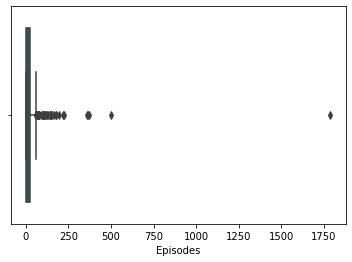

In [156]:
boxplot(df_train['Episodes'])

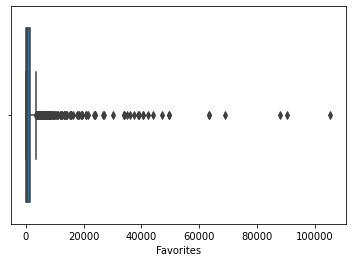

In [157]:
boxplot(df_train['Favorites'])

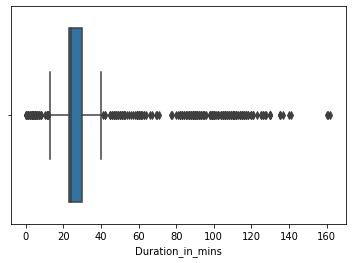

In [158]:
boxplot(df_train['Duration_in_mins'])

In [159]:
df_train = cubert_feature(df_train, 'Duration_in_mins')
df_test = cubert_feature(df_test, 'Duration_in_mins')

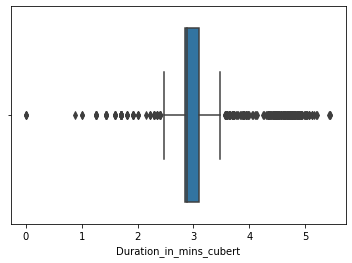

In [160]:
boxplot(df_train['Duration_in_mins_cubert'])

In [161]:
df_train, df_test = Range_Outlier(df_train, df_test, 'Duration_in_mins_cubert', [25,75], 2)

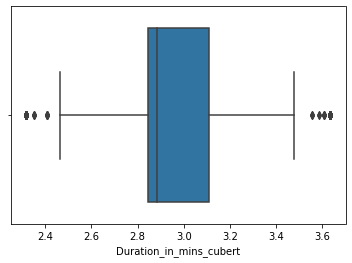

In [162]:
boxplot(df_train['Duration_in_mins_cubert'])

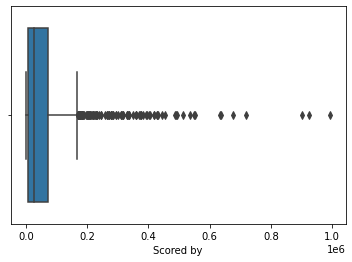

In [163]:
boxplot(df_train['Scored by'])

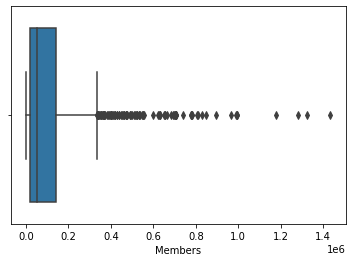

In [164]:
boxplot(df_train['Members'])

In [165]:
df_train, df_test = log2(df_train, df_test, ['Episodes', 'Favorites', 'Scored by', 'Members'])

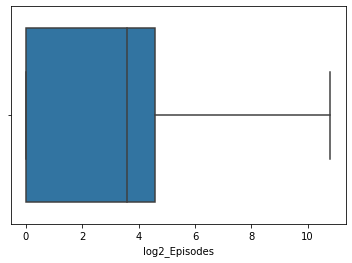

In [166]:
boxplot(df_train['log2_Episodes'])

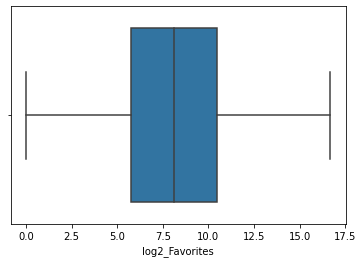

In [167]:
boxplot(df_train['log2_Favorites'])

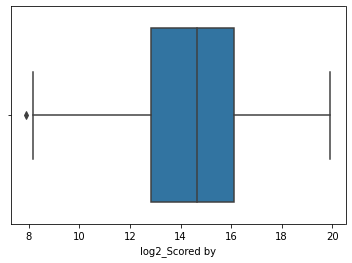

In [168]:
boxplot(df_train['log2_Scored by'])

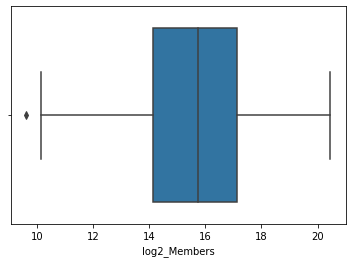

In [169]:
boxplot(df_train['log2_Members'])

In [170]:
df_train.head(2)

,Episodes,Scored by,Members,Favorites,Score,Duration_in_mins,Genres_Action,Genres_Adventure,Genres_Cars,Genres_Comedy,Genres_Dementia,Genres_Demons,Genres_Drama,Genres_Fantasy,Genres_Game,Genres_Harem,Genres_Historical,Genres_Horror,Genres_Josei,Genres_Kids,Genres_Magic,Genres_Martial Arts,Genres_Mecha,Genres_Military,Genres_Music,Genres_Mystery,Genres_Parody,Genres_Police,Genres_Psychological,Genres_Romance,Genres_Samurai,Genres_School,Genres_Sci-Fi,Genres_Seinen,Genres_Shoujo,Genres_Shoujo Ai,Genres_Shounen,Genres_Shounen Ai,Genres_Slice of Life,Genres_Space,...,"Studios_Studio Rikka,Purple Cow Studio Japan",Studios_Sunrise,"Studios_Sunrise,Ascension","Studios_Sunrise,Nakamura Production","Studios_Sunrise,Production Reed","Studios_Sunrise,Studio Deen","Studios_Sunrise,Toei Animation",Studios_SynergySP,Studios_TMS Entertainment,"Studios_TMS Entertainment,Telecom Animation Film",Studios_TROYCA,Studios_TYO Animations,Studios_Tatsunoko Production,"Studios_Tatsunoko Production,Dongwoo A&E",Studios_Telecom Animation Film,"Studios_Telecom Animation Film,Shirogumi",Studios_Telescreen BV,Studios_Tezuka Productions,"Studios_Tezuka Productions,MAPPA",Studios_Thundray,Studios_Toei Animation,"Studios_Tokyo Kids,Minami Machi Bugyousho",Studios_Tokyo Movie Shinsha,Studios_Trans Arts,Studios_Triangle Staff,Studios_Trigger,Studios_White Fox,Studios_Wit Studio,Studios_Xebec,"Studios_Xebec,AIC",Studios_Yumeta Company,Studios_Zexcs,Studios_feel.,Studios_production doA,Studios_ufotable,Duration_in_mins_cubert,log2_Episodes,log2_Favorites,log2_Scored by,log2_Members
0,49,5369,16243,359,7.87,24.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.884499,5.61471,8.487840,12.390438,13.987530
1,4,7941,14299,20,7.61,24.0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.884499,2.00000,4.321928,12.955105,13.803627


In [171]:
df_train = Drop_Columns(df_train, ['Episodes', 'Duration_in_mins', 'Favorites', 'Members', 'Scored by'])
df_test = Drop_Columns(df_test, ['Episodes', 'Duration_in_mins','Favorites', 'Members', 'Scored by'])


In [172]:
X_train, y_train, X_test, y_test = Separate_Y(df_train, df_test, 'Score')

In [173]:
X_train_scaled_SS,X_test_scaled_SS = ScaleX(X_train, X_test, ScaleType='Standard')

In [174]:
X_train_scaled_MM, X_test_scaled_MM = ScaleX(X_train, X_test, ScaleType='MinMax')

In [175]:
X_train_norm, X_test_norm = ScaleX(X_train, X_test, ScaleType='Normalize', norm='l1')

In [176]:
X_train_fs, X_test_fs = FS_KHighest(X_train_scaled_SS, y_train, X_test_scaled_SS, score_func=mutual_info_regression, k='all')

In [181]:
param_grid = {'C': [10, 15, 20], 
              'gamma': [0.01, 0.005, 0.001]
              } 
grid = GridSearchCV(SVR(), param_grid)

In [182]:
grid.fit(X_train_fs, y_train)
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
display(evaluate(grid.best_estimator_, X_test_fs, y_test))
y_pred = grid.predict(X_test)

{'C': 10, 'gamma': 0.001}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean Absolute Error: 0.20172917815922953
Mean Squared Error: 0.06704589431422488
Root Mean Squared Error: 0.25893221953674456
R-Squared:  0.3455766604256857


None

In [210]:
param_grid = {'alpha': [5, 10, 20] 
              } 
grid = GridSearchCV(Ridge(), param_grid)

In [211]:
grid.fit(X_train, y_train)
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
display(evaluate(grid.best_estimator_, X_test, y_test))
y_pred = grid.predict(X_test)

{'alpha': 10}
Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
Mean Absolute Error: 0.194125201697834
Mean Squared Error: 0.05824907013927083
Root Mean Squared Error: 0.2413484413441919
R-Squared:  0.4314409346382243


None

In [213]:
param_grid = {
    'max_depth': [75,100,120],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4],
    'n_estimators': [50, 75, 100]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid)
grid.fit(X_train_fs, y_train)
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
display(evaluate(grid.best_estimator_, X_test_fs, y_test))
y_pred = grid.predict(X_test)

{'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 75}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Mean Absolute Error: 0.2000338710098401
Mean Squared Error: 0.06403485265137138
Root Mean Squared Error: 0.25305108703850965
R-Squared:  0.3749669155748949


None

In [177]:
RF_Eval(X_train_fs, y_train, X_test_fs, y_test)

Mean Absolute Error: 0.19394011627906957
Mean Squared Error: 0.05985184734496112
Root Mean Squared Error: 0.24464637202493136
R-Squared: 0.4157965044718437


In [178]:
Lin_Reg(X_train_fs, y_train, X_test_fs, y_test)

Mean Absolute Error: 142537037344.30334
Mean Squared Error: 4.8455316409605707e+23
Root Mean Squared Error: 696098530451.011
R-Squared:  -4.729639347681337e+24


In [179]:
Ridge_Eval(X_train_fs, y_train, X_test_fs, y_test, alpha = 700)

Mean Absolute Error: 0.20562355313149952
Mean Squared Error: 0.0662832301453858
Root Mean Squared Error: 0.2574552973729338
R-Squared:  0.3530208930285976


In [180]:
SVR_Eval(X_train_fs, y_train, X_test_fs, y_test, C = 10, gamma = 0.001)

Mean Absolute Error: 0.20172917815922953
Mean Squared Error: 0.06704589431422488
Root Mean Squared Error: 0.25893221953674456
R-Squared:  0.3455766604256857


In [ ]:
X_test.to_csv("/content/drive/MyDrive/Anime_Preprocessed_Test.csv", index = False)

In [ ]:
y_test.to_csv("/content/drive/MyDrive/Anime_Preprocessed_YTest.csv", index = False)

In [ ]:
asasasa

In [ ]:
dummy_drop_list = []
for i in df_train.columns:
  if i not in df_test.columns:
    dummy_drop_list.append(i)
df_train.drop(columns = dummy_drop_list, inplace = True)
dummy_drop_list = []
for i in df_test.columns:
  if i not in df_train.columns:
    dummy_drop_list.append(i)
df_test.drop(columns = dummy_drop_list, inplace = True)

In [ ]:
df = pd.concat([df_train,df_test])
df.to_csv("/content/drive/MyDrive/Anime_Preprocessed.csv", index = False)

In [ ]:
# pca = PCA(0.99)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled)
# X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
# pca = PCA(0.7)
# pca.fit(X_train_scaled_SS)
# X_train_scaled_pca = pca.transform(X_train_scaled_SS)
# X_test_scaled_pca = pca.transform(X_test_scaled_SS)
# param_grid = {
#     'max_depth': [60,100,120],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [2,3,4],
#     'n_estimators': [75,100,250]
# }
# # 
# RFR_Grid_CV(X_train_scaled_pca, y_train, X_test_scaled_pca, y_test, param_grid)

In [ ]:
# for i in range(59,100,5):
#     print("Variance: ", i)
#     pca = PCA(i/100)
#     pca.fit(X_train_scaled)
#     X_train_scaled_pca = pca.transform(X_train_scaled_SS)
#     X_test_scaled_pca = pca.transform(X_test_scaled_SS)
#     Lin_Reg(X_train_scaled_pca, y_train, X_test_scaled_pca, y_test)

In [ ]:
# pca = PCA(0.7)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled)
# X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
# rf = RandomForestRegressor()
# rf.fit(X_train_scaled_SS, y_train)
# y_pred = rf.predict(X_test_scaled_SS)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
# print('R-Squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.20158830103359143
Mean Squared Error: 0.06700504608173977
Root Mean Squared Error: 0.25885332928463517
R-Squared: 0.3459753729343642


In [ ]:
# rf = RandomForestRegressor()
# rf.fit(X_train_scaled_MM, y_train)
# y_pred = rf.predict(X_test_scaled_MM)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
# print('R-Squared:', r2_score(y_test, y_pred))

In [ ]:
# for i in range(49,100,5):
#     print('Variance: ',i)
#     pca = PCA(i/100)
#     pca.fit(X_train_scaled_SS)
#     X_train_scaled_pca = pca.transform(X_train_scaled_SS)
#     X_test_scaled_pca = pca.transform(X_test_scaled_SS)
#     rf = RandomForestRegressor()
#     rf.fit(X_train_scaled_pca, y_train)
#     y_pred = rf.predict(X_test_scaled_pca)
#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
#     print('R-Squared:', r2_score(y_test, y_pred))

In [ ]:
# pca = PCA(0.85)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled_SS)
# X_test_scaled_pca = pca.transform(X_test_scaled_SS)
# Lin_Reg(X_train_scaled_pca, y_train, X_test_scaled_pca, y_test)

In [ ]:
# for i in range(1000,10000,100):
#     print("Alpha: ", i)
#     ls = Lasso(alpha=i/100)
#     ls.fit(X_train, y_train)
#     y_pred = ls.predict(X_test)
#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#     print("R-Squared: ", r2_score(y_test, y_pred))

In [ ]:
# param_grid = {'C': [7,8,10], 
#               'gamma': [0.005,0.002,0.001,0.0005]
#               } 

# grid = GridSearchCV(SVR(), param_grid)

# grid.fit(X_train_scaled_pca, y_train)

# print(grid.best_params_)

# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)
# display(evaluate(grid.best_estimator_, X_test_scaled_pca, y_test))

In [ ]:
# y_pred = reg.predict(X_test_scaled_pca)
# print("R-Squared: ", r2_score(y_test, y_pred))

In [ ]:
# param_grid = {'learning_rate': [0.001,0.01,0.1], 
#               'depth': [1,5,10], 
#               'iterations':[5,10,50]
#               } 
# grid = GridSearchCV(CatBoostRegressor(), param_grid)
# grid.fit(X_train_fs, y_train)
# y_pred = grid.predict(X_test_fs)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
# print('R-Squared:', r2_score(y_test, y_pred))

0:	learn: 0.3469657	total: 664us	remaining: 2.66ms
1:	learn: 0.3468950	total: 1.84ms	remaining: 2.75ms
2:	learn: 0.3468246	total: 2.46ms	remaining: 1.64ms
3:	learn: 0.3467514	total: 2.99ms	remaining: 747us
4:	learn: 0.3466804	total: 3.68ms	remaining: 0us
0:	learn: 0.3459788	total: 581us	remaining: 2.33ms
1:	learn: 0.3459203	total: 1.58ms	remaining: 2.37ms
2:	learn: 0.3458618	total: 2.27ms	remaining: 1.52ms
3:	learn: 0.3457939	total: 3.49ms	remaining: 873us
4:	learn: 0.3457307	total: 4.07ms	remaining: 0us
0:	learn: 0.3519309	total: 598us	remaining: 2.39ms
1:	learn: 0.3518659	total: 1.58ms	remaining: 2.37ms
2:	learn: 0.3518083	total: 2.37ms	remaining: 1.58ms
3:	learn: 0.3517458	total: 3.04ms	remaining: 761us
4:	learn: 0.3516862	total: 3.85ms	remaining: 0us
0:	learn: 0.3478557	total: 585us	remaining: 2.34ms
1:	learn: 0.3477873	total: 1.1ms	remaining: 1.64ms
2:	learn: 0.3477190	total: 1.57ms	remaining: 1.05ms
3:	learn: 0.3476544	total: 2.04ms	remaining: 509us
4:	learn: 0.3475899	total: 2.4

In [ ]:
# for i in range(59,100,5):
#     print("Variance: ", i)
#     pca = PCA(i/100)
#     pca.fit(X_train_scaled_SS)
#     X_train_scaled_pca = pca.transform(X_train_scaled_SS)
#     X_test_scaled_pca = pca.transform(X_test_scaled_SS)
#     svr = SVR()
#     svr.fit(X_train_scaled_pca, y_train)
#     y_pred = svr.predict(X_test_scaled_pca)
#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#     print("R-Squared: ", r2_score(y_test, y_pred))

In [ ]:
# from sklearn.decomposition import PCA
# # Make an instance of the Model
# pca = PCA(.99)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled)
# X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
# param_grid = {'C': [1,2,3], 
#               'gamma': [0.1,0.05,0.01]
#               } 
# grid = GridSearchCV(SVR(), param_grid)

# grid.fit(X_train_scaled_pca, y_train)

# print(grid.best_params_)

# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)
# display(evaluate(grid.best_estimator_, X_test_scaled_pca, y_test))

In [ ]:
# for i in range(380,410,1):
#     print("n_components: ", i)
#     pca = PCA(n_components = i)
#     pca.fit(X_train_scaled)
#     X_train_scaled_pca = pca.transform(X_train_scaled)
#     X_test_scaled_pca = pca.transform(X_test_scaled)
#     param_grid = {'C': [7,8,10], 
#                   'gamma': [0.005,0.002,0.001,0.0005]
#                   } 

#     grid = GridSearchCV(SVR(), param_grid)

#     grid.fit(X_train_scaled_pca, y_train)

#     print(grid.best_params_)

#     # print how our model looks after hyper-parameter tuning
#     print(grid.best_estimator_)
#     display(evaluate(grid.best_estimator_, X_test_scaled_pca, y_test))

In [ ]:
# pca = PCA(0.99)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled_SS)
# X_test_scaled_pca = pca.transform(X_test_scaled_SS)
# rdg = Ridge(alpha=750)
# rdg.fit(X_train_scaled_pca, y_train)
# y_pred = rdg.predict(X_test_scaled_pca)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("R-Squared: ", r2_score(y_test, y_pred))

In [ ]:
# Retained_List = df_train.columns
# len(Retained_List)

In [ ]:
# df_train, df_test = Remove_Multicolliearity(df_train, df_test, "Score")

In [ ]:
# pd.options.display.max_seq_items = 2000
# df_train.columns, df_test.columns

In [ ]:
# # below columns are retained after removing multicollinearity
# df_train = df_train.loc[:, df_train.columns.intersection(['Duration_in_mins_cubert','Favorites_log2','Episodes_log2','Type_Music', 'Type_ONA', 'Type_OVA',
#         'Type_Special', 'Rating_PG', 'Rating_R', 'Sources_Book', 'Sources_Game',
#         'Sources_Light novel', 'Sources_Music', 'Sources_Novel',
#         'Sources_Original', 'Sources_Other', 'Sources_Picture book',
#         'Sources_Visual novel', 'Sources_Web manga', 'Start airing Month_2',
#         'Start airing Month_3', 'Start airing Month_4', 'Start airing Month_5',
#         'Start airing Month_6', 'Start airing Month_7', 'Start airing Month_8',
#         'Start airing Month_9', 'Start airing Month_10',
#         'Start airing Month_11', 'Start airing Month_12',
#         'Start airing Year Period_(2003.0, 2009.0]',
#         'Start airing Year Period_(2009.0, 2012.0]',
#         'Start airing Year Period_(2012.0, 2015.0]',
#         'Start airing Year Period_(2015.0, 2018.0]',
#         'End airing Year Period_(2007.0, 2013.0]',
#         'End airing Year Period_(2013.0, 2017.0]',
#         'Genres_Action', 'Genres_Adventure', 'Genres_Cars', 'Genres_Comedy',
#         'Genres_Dementia', 'Genres_Demons', 'Genres_Drama', 'Genres_Fantasy',
#         'Genres_Game', 'Genres_Harem', 'Genres_Historical', 'Genres_Horror',
#         'Genres_Josei', 'Genres_Kids', 'Genres_Magic', 'Genres_Martial Arts',
#         'Genres_Mecha', 'Genres_Military', 'Genres_Music', 'Genres_Mystery',
#         'Genres_Parody', 'Genres_Police', 'Genres_Psychological',
#         'Genres_Romance', 'Genres_Samurai', 'Genres_School', 'Genres_Sci-Fi',
#         'Genres_Seinen', 'Genres_Shoujo', 'Genres_Shoujo Ai', 'Genres_Shounen',
#         'Genres_Shounen Ai', 'Genres_Slice of Life', 'Genres_Space',
#         'Genres_Sports', 'Genres_Super Power', 'Genres_Supernatural',
#         'Genres_Thriller', 'Genres_Vampire', 'Producers_A-Sketch',
#         'Producers_ABC Animation', 'Producers_AIC',
#         'Producers_ASCII Media Works', 'Producers_AT-X',
#         'Producers_Academy Productions', 'Producers_Age Global Networks',
#         'Producers_Ai Addiction', 'Producers_Akita Shoten',
#         'Producers_Animation Do', 'Producers_Animax',
#         'Producers_Asahi Broadcasting', 'Producers_Ashi Production',
#         'Producers_Asmik Ace Entertainment', 'Producers_Atelier Musa',
#         'Producers_Atlus', 'Producers_Avex Entertainment',
#         'Producers_Avex Pictures', 'Producers_BS Fuji', 'Producers_BS11',
#         'Producers_Bandai', 'Producers_Bandai Namco Entertainment',
#         'Producers_Bandai Namco Games', 'Producers_Bandai Namco Live Creative',
#         'Producers_Bandai Visual', 'Producers_Big West', 'Producers_Bushiroad',
#         'Producers_CBC', 'Producers_CoMix Wave Films',
#         'Producers_Cyclone Graphics inc', 'Producers_Cygames',
#         'Producers_DAX Production', 'Producers_Daiichi Shokai CO.',
#         'Producers_Daiichikosho', 'Producers_Delfi Sound', 'Producers_Dentsu',
#         'Producers_Dynamic Planning',
#         'Producers_East Japan Marketing & Communications',
#         'Producers_Enterbrain', 'Producers_Flex Comix',
#         'Producers_Frontier Works', 'Producers_Fuji Pacific Music Publishing',
#         'Producers_Fuji TV', 'Producers_Furyu', 'Producers_GANSIS',
#         'Producers_GDH', 'Producers_GYAO!', 'Producers_Genco',
#         'Producers_Geneon Universal Entertainment', 'Producers_Glovision',
#         'Producers_Good Smile Company', 'Producers_Grooove',
#         'Producers_Group TAC', 'Producers_Hakuhodo DY Media Partners',
#         'Producers_Hakuhodo DY Music & Pictures', 'Producers_Hakusensha',
#         'Producers_Hal Film Maker', 'Producers_Half H.P Studio',
#         'Producers_Happinet Pictures', 'Producers_Houbunsha',
#         'Producers_Ichijinsha', 'Producers_Imagica', 'Producers_Imagin',
#         'Producers_J.C.Staff', 'Producers_Jade Animation', 'Producers_Kadokawa',
#         'Producers_Kadokawa Contents Gate', 'Producers_Kadokawa Pictures Japan',
#         'Producers_Kadokawa Shoten', 'Producers_Kanetsu Co.',
#         'Producers_Kansai Telecasting', 'Producers_King Records',
#         'Producers_Kinyosha', 'Producers_Kitty Films', 'Producers_KlockWorx',
#         'Producers_Kodansha', 'Producers_Kyoraku Industrial Holdings',
#         'Producers_Lantis', 'Producers_Lawson', 'Producers_MAGES.',
#         'Producers_Madoka Partners', 'Producers_Mag Garden',
#         'Producers_Magic Capsule', 'Producers_Mainichi Broadcasting System',
#         'Producers_Marvelous', 'Producers_Marvelous AQL',
#         'Producers_Media Factory', 'Producers_MediaNet',
#         'Producers_Medicos Entertainment', 'Producers_Memory-Tech',
#         'Producers_Miracle Robo', 'Producers_Movic',
#         'Producers_NBCUniversal Entertainment Japan', 'Producers_NHK',
#         'Producers_NTT Docomo', 'Producers_NTT Plala', 'Producers_Nichion',
#         'Producers_Nippon Columbia', 'Producers_Nippon Television Network',
#         'Producers_Nitroplus', 'Producers_Notes', 'Producers_Omnibus Japan',
#         'Producers_Pioneer LDC', 'Producers_Pony Canyon',
#         'Producers_Production I.G', 'Producers_RAY',
#         'Producers_RCC Chugoku Broadcasting', 'Producers_Rakuonsha',
#         'Producers_Romantica club !!', 'Producers_Rondo Robe',
#         'Producers_SKY Perfect Well Think', 'Producers_SME Visual Works',
#         'Producers_Sakura Create', 'Producers_Sammy', 'Producers_Sega',
#         'Producers_Seikaisha', 'Producers_Shochiku', 'Producers_Shogakukan',
#         'Producers_Shogakukan Productions', 'Producers_Shounen Gahousha',
#         'Producers_Showgate', 'Producers_Shueisha',
#         'Producers_SoftBank Creative Corp.', 'Producers_SoftX',
#         'Producers_Sogo Vision', 'Producers_Sony Music Communications',
#         'Producers_Sony Music Entertainment', 'Producers_Sony PCL',
#         'Producers_Sotsu', 'Producers_Starchild Records',
#         'Producers_Studio Jack', 'Producers_Studio Mausu',
#         'Producers_Sunny Side Up', 'Producers_T.O Entertainment',
#         'Producers_TAP', 'Producers_TBS', 'Producers_TMS Entertainment',
#         'Producers_TOHO animation', 'Producers_TV Asahi',
#         'Producers_TV Tokyo Music', 'Producers_Telescreen BV',
#         'Producers_Tencent Penguin Pictures', 'Producers_The Answer Studio',
#         'Producers_Toei Video', 'Producers_Toho',
#         'Producers_Tohokushinsha Film Corporation',
#         'Producers_Tokuma Japan Communications', 'Producers_Tokuma Shoten',
#         'Producers_Tokyo MX', 'Producers_Tokyo Movie Shinsha',
#         'Producers_Toranoana', 'Producers_Toshiba Entertainment',
#         'Producers_Toy\'s Factory', 'Producers_Trinity Sound', 'Producers_VAP',
#         'Producers_Victor Entertainment', 'Producers_Visual Art\'s',
#         'Producers_WAO World', 'Producers_Warner Bros.', 'Producers_YTV',
#         'Producers_Yahoo! Japan', 'Producers_Yomiko Advertising',
#         'Producers_Yomiuri Advertising', 'Producers_Yomiuri TV Enterprise',
#         'Producers_Yomiuri Telecasting', 'Producers_bilibili',
#         'Producers_d-rights', 'Producers_flying DOG', 'Producers_i0+',
#         'Licensors_4Kids Entertainment', 'Licensors_ADV Films',
#         'Licensors_AnimEigo', 'Licensors_Aniplex of America',
#         'Licensors_Bandai Visual USA', 'Licensors_Central Park Media',
#         'Licensors_Crunchyroll', 'Licensors_DiC Entertainment',
#         'Licensors_Enoki Films', 'Licensors_Flatiron Film Company',
#         'Licensors_Funimation', 'Licensors_GKIDS',
#         'Licensors_Geneon Entertainment USA', 'Licensors_Kadokawa Pictures USA',
#         'Licensors_Maiden Japan', 'Licensors_Manga Entertainment',
#         'Licensors_Media Blasters', 'Licensors_NIS America',
#         'Licensors_NYAV Post', 'Licensors_Nozomi Entertainment',
#         'Licensors_Ponycan USA', 'Licensors_Saban Entertainment',
#         'Licensors_Sentai Filmworks', 'Licensors_Shout! Factory',
#         'Licensors_Sony Pictures Entertainment', 'Licensors_TOKYOPOP',
#         'Licensors_The Pokemon Company International', 'Licensors_Viz Media',
#         'Licensors_Walt Disney Studios', 'Licensors_Warner Bros.',
#         'Studios_8bit', 'Studios_A-1 Pictures', 'Studios_A.C.G.T.',
#         'Studios_AIC', 'Studios_AIC A.S.T.A.', 'Studios_AIC Classic',
#         'Studios_Actas', 'Studios_Artland', 'Studios_Bandai Namco Pictures',
#         'Studios_Bee Train', 'Studios_Bones', 'Studios_Brain\'s Base',
#         'Studios_Brain\'s Base,Marvy Jack', 'Studios_Bridge',
#         'Studios_CoMix Wave Films', 'Studios_David Production',
#         'Studios_Doga Kobo', 'Studios_E&G Films', 'Studios_Fanworks',
#         'Studios_G.CMay Animation & Film', 'Studios_Gainax', 'Studios_GoHands',
#         'Studios_Gonzo', 'Studios_Group TAC', 'Studios_Hal Film Maker',
#         'Studios_Haoliners Animation League', 'Studios_J.C.Staff',
#         'Studios_J.C.Staff,Egg Firm', 'Studios_Kinema Citrus',
#         'Studios_Kyoto Animation', 'Studios_LIDENFILMS', 'Studios_Lay-duce',
#         'Studios_Lerche', 'Studios_M.S.C', 'Studios_MAPPA', 'Studios_Madhouse',
#         'Studios_Madhouse,TMS Entertainment', 'Studios_Magic Bus',
#         'Studios_Manglobe', 'Studios_Mushi Production',
#         'Studios_Nippon Animation', 'Studios_OLM', 'Studios_P.A. Works',
#         'Studios_Polygon Pictures', 'Studios_Production I.G',
#         'Studios_Production I.G,M.S.C', 'Studios_Production I.G,Madhouse',
#         'Studios_Production I.G,Xebec', 'Studios_Production IMS',
#         'Studios_SANZIGEN', 'Studios_SANZIGEN,LIDENFILMS', 'Studios_Satelight',
#         'Studios_Seven', 'Studios_Seven Arcs', 'Studios_Shaft',
#         'Studios_Shin-Ei Animation', 'Studios_Shuka', 'Studios_Silver Link.',
#         'Studios_Studio Comet', 'Studios_Studio Deen', 'Studios_Studio Gallop',
#         'Studios_Studio Ghibli', 'Studios_Studio Gokumi',
#         'Studios_Studio Hibari', 'Studios_Studio Pierrot',
#         'Studios_Studio Rikka', 'Studios_SynergySP',
#         'Studios_TMS Entertainment', 'Studios_TROYCA', 'Studios_TYO Animations',
#         'Studios_Tatsunoko Production',
#         'Studios_Tatsunoko Production,Dongwoo A&E',
#         'Studios_Telecom Animation Film', 'Studios_Tezuka Productions',
#         'Studios_Toei Animation', 'Studios_Tokyo Movie Shinsha',
#         'Studios_Trans Arts', 'Studios_Triangle Staff', 'Studios_Trigger',
#         'Studios_White Fox', 'Studios_Wit Studio', 'Studios_Xebec',
#         'Studios_feel.', 'Studios_ufotable', 'Score'])]
# df_test = df_test.loc[:, df_test.columns.intersection(['Duration_in_mins_cubert','Favorites_log2','Episodes_log2', 'Type_Music', 'Type_ONA', 'Type_OVA',
#         'Type_Special', 'Rating_PG', 'Rating_R', 'Sources_Book', 'Sources_Game',
#         'Sources_Light novel', 'Sources_Music', 'Sources_Novel',
#         'Sources_Original', 'Sources_Other', 'Sources_Picture book',
#         'Sources_Visual novel', 'Sources_Web manga', 'Start airing Month_2',
#         'Start airing Month_3', 'Start airing Month_4', 'Start airing Month_5',
#         'Start airing Month_6', 'Start airing Month_7', 'Start airing Month_8',
#         'Start airing Month_9', 'Start airing Month_10',
#         'Start airing Month_11', 'Start airing Month_12',
#         'Start airing Year Period_(2003.0, 2009.0]',
#         'Start airing Year Period_(2009.0, 2012.0]',
#         'Start airing Year Period_(2012.0, 2015.0]',
#         'Start airing Year Period_(2015.0, 2018.0]',
#         'End airing Year Period_(2007.0, 2013.0]',
#         'End airing Year Period_(2013.0, 2017.0]',
#         'Genres_Action', 'Genres_Adventure', 'Genres_Cars', 'Genres_Comedy',
#         'Genres_Dementia', 'Genres_Demons', 'Genres_Drama', 'Genres_Fantasy',
#         'Genres_Game', 'Genres_Harem', 'Genres_Historical', 'Genres_Horror',
#         'Genres_Josei', 'Genres_Kids', 'Genres_Magic', 'Genres_Martial Arts',
#         'Genres_Mecha', 'Genres_Military', 'Genres_Music', 'Genres_Mystery',
#         'Genres_Parody', 'Genres_Police', 'Genres_Psychological',
#         'Genres_Romance', 'Genres_Samurai', 'Genres_School', 'Genres_Sci-Fi',
#         'Genres_Seinen', 'Genres_Shoujo', 'Genres_Shoujo Ai', 'Genres_Shounen',
#         'Genres_Shounen Ai', 'Genres_Slice of Life', 'Genres_Space',
#         'Genres_Sports', 'Genres_Super Power', 'Genres_Supernatural',
#         'Genres_Thriller', 'Genres_Vampire', 'Producers_A-Sketch',
#         'Producers_ABC Animation', 'Producers_AIC',
#         'Producers_ASCII Media Works', 'Producers_AT-X',
#         'Producers_Academy Productions', 'Producers_Age Global Networks',
#         'Producers_Ai Addiction', 'Producers_Akita Shoten',
#         'Producers_Animation Do', 'Producers_Animax',
#         'Producers_Asahi Broadcasting', 'Producers_Ashi Production',
#         'Producers_Asmik Ace Entertainment', 'Producers_Atelier Musa',
#         'Producers_Atlus', 'Producers_Avex Entertainment',
#         'Producers_Avex Pictures', 'Producers_BS Fuji', 'Producers_BS11',
#         'Producers_Bandai', 'Producers_Bandai Namco Entertainment',
#         'Producers_Bandai Namco Games', 'Producers_Bandai Namco Live Creative',
#         'Producers_Bandai Visual', 'Producers_Big West', 'Producers_Bushiroad',
#         'Producers_CBC', 'Producers_CoMix Wave Films',
#         'Producers_Cyclone Graphics inc', 'Producers_Cygames',
#         'Producers_DAX Production', 'Producers_Daiichi Shokai CO.',
#         'Producers_Daiichikosho', 'Producers_Delfi Sound', 'Producers_Dentsu',
#         'Producers_Dynamic Planning',
#         'Producers_East Japan Marketing & Communications',
#         'Producers_Enterbrain', 'Producers_Flex Comix',
#         'Producers_Frontier Works', 'Producers_Fuji Pacific Music Publishing',
#         'Producers_Fuji TV', 'Producers_Furyu', 'Producers_GANSIS',
#         'Producers_GDH', 'Producers_GYAO!', 'Producers_Genco',
#         'Producers_Geneon Universal Entertainment', 'Producers_Glovision',
#         'Producers_Good Smile Company', 'Producers_Grooove',
#         'Producers_Group TAC', 'Producers_Hakuhodo DY Media Partners',
#         'Producers_Hakuhodo DY Music & Pictures', 'Producers_Hakusensha',
#         'Producers_Hal Film Maker', 'Producers_Half H.P Studio',
#         'Producers_Happinet Pictures', 'Producers_Houbunsha',
#         'Producers_Ichijinsha', 'Producers_Imagica', 'Producers_Imagin',
#         'Producers_J.C.Staff', 'Producers_Jade Animation', 'Producers_Kadokawa',
#         'Producers_Kadokawa Contents Gate', 'Producers_Kadokawa Pictures Japan',
#         'Producers_Kadokawa Shoten', 'Producers_Kanetsu Co.',
#         'Producers_Kansai Telecasting', 'Producers_King Records',
#         'Producers_Kinyosha', 'Producers_Kitty Films', 'Producers_KlockWorx',
#         'Producers_Kodansha', 'Producers_Kyoraku Industrial Holdings',
#         'Producers_Lantis', 'Producers_Lawson', 'Producers_MAGES.',
#         'Producers_Madoka Partners', 'Producers_Mag Garden',
#         'Producers_Magic Capsule', 'Producers_Mainichi Broadcasting System',
#         'Producers_Marvelous', 'Producers_Marvelous AQL',
#         'Producers_Media Factory', 'Producers_MediaNet',
#         'Producers_Medicos Entertainment', 'Producers_Memory-Tech',
#         'Producers_Miracle Robo', 'Producers_Movic',
#         'Producers_NBCUniversal Entertainment Japan', 'Producers_NHK',
#         'Producers_NTT Docomo', 'Producers_NTT Plala', 'Producers_Nichion',
#         'Producers_Nippon Columbia', 'Producers_Nippon Television Network',
#         'Producers_Nitroplus', 'Producers_Notes', 'Producers_Omnibus Japan',
#         'Producers_Pioneer LDC', 'Producers_Pony Canyon',
#         'Producers_Production I.G', 'Producers_RAY',
#         'Producers_RCC Chugoku Broadcasting', 'Producers_Rakuonsha',
#         'Producers_Romantica club !!', 'Producers_Rondo Robe',
#         'Producers_SKY Perfect Well Think', 'Producers_SME Visual Works',
#         'Producers_Sakura Create', 'Producers_Sammy', 'Producers_Sega',
#         'Producers_Seikaisha', 'Producers_Shochiku', 'Producers_Shogakukan',
#         'Producers_Shogakukan Productions', 'Producers_Shounen Gahousha',
#         'Producers_Showgate', 'Producers_Shueisha',
#         'Producers_SoftBank Creative Corp.', 'Producers_SoftX',
#         'Producers_Sogo Vision', 'Producers_Sony Music Communications',
#         'Producers_Sony Music Entertainment', 'Producers_Sony PCL',
#         'Producers_Sotsu', 'Producers_Starchild Records',
#         'Producers_Studio Jack', 'Producers_Studio Mausu',
#         'Producers_Sunny Side Up', 'Producers_T.O Entertainment',
#         'Producers_TAP', 'Producers_TBS', 'Producers_TMS Entertainment',
#         'Producers_TOHO animation', 'Producers_TV Asahi',
#         'Producers_TV Tokyo Music', 'Producers_Telescreen BV',
#         'Producers_Tencent Penguin Pictures', 'Producers_The Answer Studio',
#         'Producers_Toei Video', 'Producers_Toho',
#         'Producers_Tohokushinsha Film Corporation',
#         'Producers_Tokuma Japan Communications', 'Producers_Tokuma Shoten',
#         'Producers_Tokyo MX', 'Producers_Tokyo Movie Shinsha',
#         'Producers_Toranoana', 'Producers_Toshiba Entertainment',
#         'Producers_Toy\'s Factory', 'Producers_Trinity Sound', 'Producers_VAP',
#         'Producers_Victor Entertainment', 'Producers_Visual Art\'s',
#         'Producers_WAO World', 'Producers_Warner Bros.', 'Producers_YTV',
#         'Producers_Yahoo! Japan', 'Producers_Yomiko Advertising',
#         'Producers_Yomiuri Advertising', 'Producers_Yomiuri TV Enterprise',
#         'Producers_Yomiuri Telecasting', 'Producers_bilibili',
#         'Producers_d-rights', 'Producers_flying DOG', 'Producers_i0+',
#         'Licensors_4Kids Entertainment', 'Licensors_ADV Films',
#         'Licensors_AnimEigo', 'Licensors_Aniplex of America',
#         'Licensors_Bandai Visual USA', 'Licensors_Central Park Media',
#         'Licensors_Crunchyroll', 'Licensors_DiC Entertainment',
#         'Licensors_Enoki Films', 'Licensors_Flatiron Film Company',
#         'Licensors_Funimation', 'Licensors_GKIDS',
#         'Licensors_Geneon Entertainment USA', 'Licensors_Kadokawa Pictures USA',
#         'Licensors_Maiden Japan', 'Licensors_Manga Entertainment',
#         'Licensors_Media Blasters', 'Licensors_NIS America',
#         'Licensors_NYAV Post', 'Licensors_Nozomi Entertainment',
#         'Licensors_Ponycan USA', 'Licensors_Saban Entertainment',
#         'Licensors_Sentai Filmworks', 'Licensors_Shout! Factory',
#         'Licensors_Sony Pictures Entertainment', 'Licensors_TOKYOPOP',
#         'Licensors_The Pokemon Company International', 'Licensors_Viz Media',
#         'Licensors_Walt Disney Studios', 'Licensors_Warner Bros.',
#         'Studios_8bit', 'Studios_A-1 Pictures', 'Studios_A.C.G.T.',
#         'Studios_AIC', 'Studios_AIC A.S.T.A.', 'Studios_AIC Classic',
#         'Studios_Actas', 'Studios_Artland', 'Studios_Bandai Namco Pictures',
#         'Studios_Bee Train', 'Studios_Bones', 'Studios_Brain\'s Base',
#         'Studios_Brain\'s Base,Marvy Jack', 'Studios_Bridge',
#         'Studios_CoMix Wave Films', 'Studios_David Production',
#         'Studios_Doga Kobo', 'Studios_E&G Films', 'Studios_Fanworks',
#         'Studios_G.CMay Animation & Film', 'Studios_Gainax', 'Studios_GoHands',
#         'Studios_Gonzo', 'Studios_Group TAC', 'Studios_Hal Film Maker',
#         'Studios_Haoliners Animation League', 'Studios_J.C.Staff',
#         'Studios_J.C.Staff,Egg Firm', 'Studios_Kinema Citrus',
#         'Studios_Kyoto Animation', 'Studios_LIDENFILMS', 'Studios_Lay-duce',
#         'Studios_Lerche', 'Studios_M.S.C', 'Studios_MAPPA', 'Studios_Madhouse',
#         'Studios_Madhouse,TMS Entertainment', 'Studios_Magic Bus',
#         'Studios_Manglobe', 'Studios_Mushi Production',
#         'Studios_Nippon Animation', 'Studios_OLM', 'Studios_P.A. Works',
#         'Studios_Polygon Pictures', 'Studios_Production I.G',
#         'Studios_Production I.G,M.S.C', 'Studios_Production I.G,Madhouse',
#         'Studios_Production I.G,Xebec', 'Studios_Production IMS',
#         'Studios_SANZIGEN', 'Studios_SANZIGEN,LIDENFILMS', 'Studios_Satelight',
#         'Studios_Seven', 'Studios_Seven Arcs', 'Studios_Shaft',
#         'Studios_Shin-Ei Animation', 'Studios_Shuka', 'Studios_Silver Link.',
#         'Studios_Studio Comet', 'Studios_Studio Deen', 'Studios_Studio Gallop',
#         'Studios_Studio Ghibli', 'Studios_Studio Gokumi',
#         'Studios_Studio Hibari', 'Studios_Studio Pierrot',
#         'Studios_Studio Rikka', 'Studios_SynergySP',
#         'Studios_TMS Entertainment', 'Studios_TROYCA', 'Studios_TYO Animations',
#         'Studios_Tatsunoko Production',
#         'Studios_Tatsunoko Production,Dongwoo A&E',
#         'Studios_Telecom Animation Film', 'Studios_Tezuka Productions',
#         'Studios_Toei Animation', 'Studios_Tokyo Movie Shinsha',
#         'Studios_Trans Arts', 'Studios_Triangle Staff', 'Studios_Trigger',
#         'Studios_White Fox', 'Studios_Wit Studio', 'Studios_Xebec',
#         'Studios_feel.', 'Studios_ufotable', 'Score'])]
